# Desenvolvimento em Keras

Nesse problema de Data Science, o que se quer é criar um modelo que consiga prever a potência gerada instatânea gerada pelo aerogerador através da velocidade e direção do vento.

### 1. Aquisição de dados

In [2]:
# Importando dados
import pandas as pd

filename = 'T1.csv'
df = pd.read_csv(filename)

df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
Date/Time                        50530 non-null object
LV ActivePower (kW)              50530 non-null float64
Wind Speed (m/s)                 50530 non-null float64
Theoretical_Power_Curve (KWh)    50530 non-null float64
Wind Direction (°)               50530 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


Não há presença de objetos nulos

In [4]:
#Passando DateTime para o tipo datetime

df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
Date/Time                        50530 non-null datetime64[ns]
LV ActivePower (kW)              50530 non-null float64
Wind Speed (m/s)                 50530 non-null float64
Theoretical_Power_Curve (KWh)    50530 non-null float64
Wind Direction (°)               50530 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


In [5]:
df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


### 2. Desbravando dados

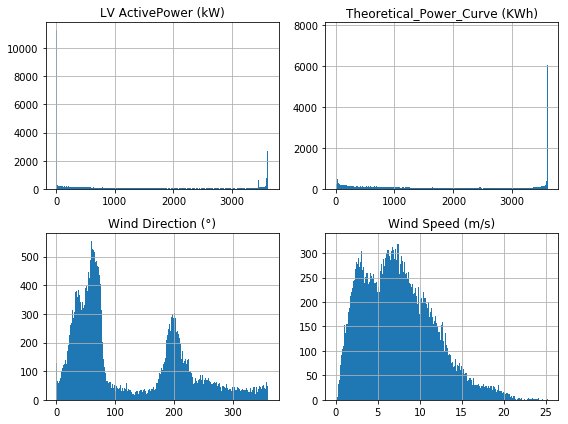

In [6]:
# Plotando histogramas dos dados

import matplotlib.pyplot as plt
%matplotlib inline  
df.hist(bins=400, figsize=(8,6))
plt.tight_layout()
plt.show()

In [7]:
df.corr()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
LV ActivePower (kW),1.000000,0.912774,0.949918,-0.062702
Wind Speed (m/s),0.912774,1.000000,0.944209,-0.077188
Theoretical_Power_Curve (KWh),0.949918,0.944209,1.000000,-0.099076
Wind Direction (°),-0.062702,-0.077188,-0.099076,1.000000


### 3. Preparando os dados para a rede neural

##### 3.1 Remoção de números negativos

In [8]:
for cols in df.columns.tolist()[1:]:
    df = df.loc[df[cols] > 0]

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,39265.000000,39265.000000,39265.000000,39265.000000
mean,1682.757970,8.835618,1849.600792,115.081817
std,1259.248116,3.740388,1299.455462,86.093682
min,0.028733,3.002270,16.073052,0.015678
25%,504.130402,5.985851,620.233851,48.838100
50%,1421.088989,8.168509,1627.920349,69.959221
75%,2925.330078,11.145490,3321.427096,197.017807
max,3618.732910,25.206011,3600.000000,359.997589


##### 3.2 Remoção de outliers

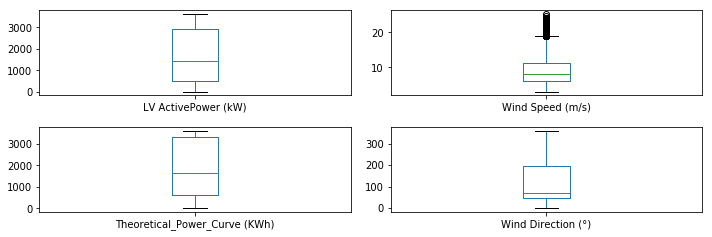

In [9]:
cols = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
cols

# Exploratory Data Analysis
# Identfy the KDE shape for all columns (gaussian distribution?)

df[cols].plot(kind='box',
            layout=(5,2),
            subplots=True,
            figsize=(10,8),
            sharex=False)

plt.tight_layout()
plt.show()

Nota-se, pelos gráficos acima, que a variável Wind Speed aprensenta alguns outliers que devem ser removidos do Dataset. Dessa forma, eles serão removidos utilizando a seguinte formula: $$ Q3 + 1.5*AIQ < Outlier < Q1 - 1.5*AIQ $$ aonde AIQ significa amplitude interquartil

In [10]:
WS_Q1 = df['Wind Speed (m/s)'].quantile(0.25)
WS_Q3 = df['Wind Speed (m/s)'].quantile(0.75)

WS_IQR = WS_Q3 - WS_Q1

df = df.loc[df['Wind Speed (m/s)'] > WS_Q1 - 1.5*WS_IQR]
df = df.loc[df['Wind Speed (m/s)'] < WS_Q3 + 1.5*WS_IQR]

df.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,38653.000000,38653.000000,38653.000000,38653.000000
mean,1653.003972,8.655582,1821.886402,113.794714
std,1246.467008,3.479963,1290.751814,86.144154
min,0.028733,3.002270,16.073052,0.015678
25%,493.298187,5.954392,609.712191,48.394951
50%,1382.901001,8.092525,1583.418531,69.302498
75%,2849.197021,10.978900,3264.941266,196.646606
max,3618.732910,18.884310,3600.000000,359.997589


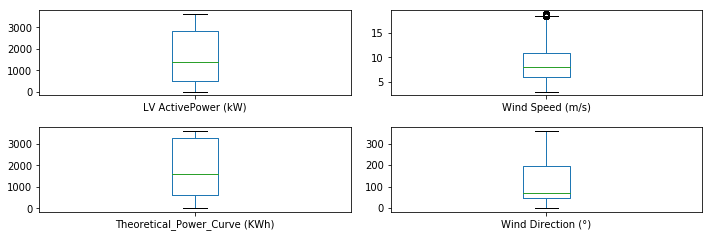

In [11]:
df[cols].plot(kind='box',
            layout=(5,2),
            subplots=True,
            figsize=(10,8),
            sharex=False)

plt.tight_layout()
plt.show()

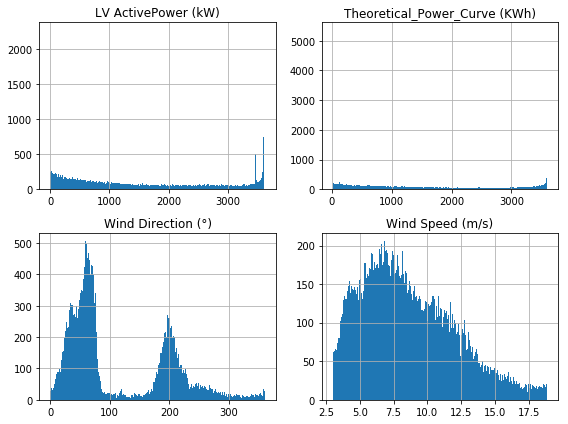

In [12]:
# Plotando histogramas dos dados

import matplotlib.pyplot as plt
%matplotlib inline  
df.hist(bins=400, figsize=(8,6))
plt.tight_layout()
plt.show()

##### 3.3 Separando em banco de dados de treinamento e teste

Os dados serão divididos em 80% treinamento e velidação e 20% para teste

In [13]:
train_lengh = int(len(df)*0.8)
train_data = df[0:train_lengh]

test_lengh = train_lengh + int(len(df)*0.2)
test_data = df[train_lengh:test_lengh]

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30922 entries, 0 to 40715
Data columns (total 5 columns):
Date/Time                        30922 non-null datetime64[ns]
LV ActivePower (kW)              30922 non-null float64
Wind Speed (m/s)                 30922 non-null float64
Theoretical_Power_Curve (KWh)    30922 non-null float64
Wind Direction (°)               30922 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7730 entries, 40716 to 50528
Data columns (total 5 columns):
Date/Time                        7730 non-null datetime64[ns]
LV ActivePower (kW)              7730 non-null float64
Wind Speed (m/s)                 7730 non-null float64
Theoretical_Power_Curve (KWh)    7730 non-null float64
Wind Direction (°)               7730 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 362.3 KB


#### 3.4 Escalonamento de dados de treinamento

In [14]:
dfn = train_data.copy()

i = ['Theoretical_Power_Curve (KWh)' ,'Wind Speed (m/s)', 'Wind Direction (°)', 'LV ActivePower (kW)']
for j in i:
    a = df[j].max()
    b = df[j].min()
    dfn[j] = (dfn[j]-b)/(a-b)
    
dfn.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,30922.000000,30922.000000,30922.000000,30922.000000
mean,0.442872,0.345646,0.489012,0.306710
std,0.344036,0.217616,0.362134,0.238033
min,0.000000,0.000000,0.000000,0.000000
25%,0.123243,0.173925,0.148538,0.131698
50%,0.362809,0.310413,0.411665,0.185963
75%,0.767142,0.493786,0.892512,0.542174
max,1.000000,1.000000,1.000000,0.999745


#### 3.5 Definindo features e targets

In [15]:
import numpy as np

features_train, targets_train = dfn[['Wind Speed (m/s)',"Wind Direction (°)"]], dfn['LV ActivePower (kW)']

# transformando em arrays

features_train = np.array(features_train)
targets_train = np.array(targets_train)

print(features_train.shape)
print(targets_train.shape)

(30922, 2)
(30922,)


### 4. Seleção do modelo

O modelo proposto em Schlechtingen e Santos (2011) é uma rede neural do tipo feedforward com 5 neurons na hidden layer, como mostrado na figura a seguir:

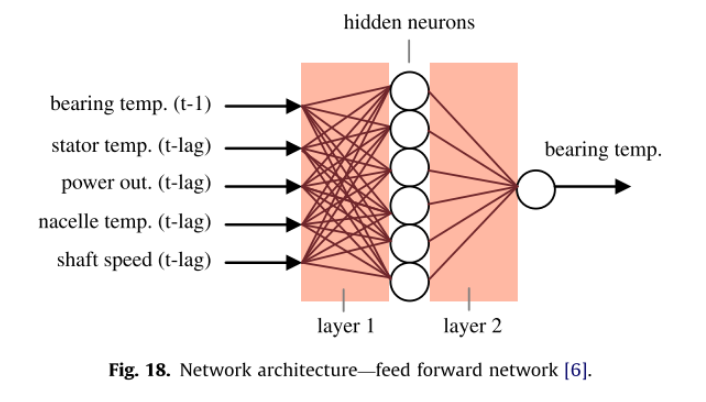

Os sinais de input, para o caso específico dessa simulação, serão Velocidade do Vento (Wind Speed) e Direção (Wind Direction), e a saída será a Potência de Saída (Power Output).

A função de ativação será a função Sigmoide.

Método de treinamento: Gradiente descendente com momento.

Pesos iniciados aleatóriamente.



In [16]:
# Importando keras

from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [17]:
# definindo o modelo keras

model = Sequential()
model.add(Dense(5, input_dim = 2, activation = 'sigmoid'))
model.add(Dense(1, activation = 'linear'))

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
# compilando o modelo keras

model.compile(loss='mean_squared_error', optimizer = 'adam')

### 5. Treinando a rede neural

In [20]:
# fitting the model

X= features_train
y= targets_train

model.fit(X, y, epochs = 2, batch_size = 1)

Epoch 1/2
30922/30922 [==============================] - 24s 782us/step - loss: 0.0071
Epoch 2/2
30922/30922 [==============================] - 23s 739us/step - loss: 0.0063


In [21]:
# evaluating training loss

loss = model.evaluate(X, y)
print(loss)

30922/30922 [==============================] - 0s 15us/step
0.005774402465355298


### 6. Teste da rede neural

In [22]:
# preparando os dados de teste

dfnt = test_data.copy()

i = ['Theoretical_Power_Curve (KWh)' ,'Wind Speed (m/s)', 'Wind Direction (°)', 'LV ActivePower (kW)']
for j in i:
    a = df[j].max()
    b = df[j].min()
    dfnt[j] = (dfnt[j]-b)/(a-b)
    
dfnt.describe()


,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,7730.000000,7730.000000,7730.000000,7730.000000
mean,0.512408,0.397189,0.563242,0.353518
std,0.340498,0.220256,0.345820,0.240724
min,0.000003,0.000526,0.000077,0.000039
25%,0.195715,0.230416,0.238468,0.155223
50%,0.467863,0.359031,0.541134,0.238869
75%,0.862999,0.533670,0.948756,0.555698
max,0.996061,0.999781,1.000000,1.000000


In [23]:
# making predictions out of the test set

X_test = dfnt[['Wind Speed (m/s)','Wind Direction (°)']]
testing = model.predict(X_test)

testing = np.array(testing)
print(testing.shape)

(7730, 1)


In [24]:
# evaluating test error

y_testing = np.array(dfnt['LV ActivePower (kW)']).reshape(-1, 1)
error = testing - y_testing

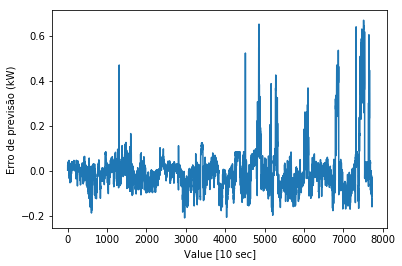

In [25]:
# plotting error

x = np.arange(1, len(y_testing)+1, 1)
y = error

plt.xlabel('Value [10 sec]')
plt.ylabel('Erro de previsão (kW)')
plt.plot(x, y) 

#### 6.1 Aplicando o gráfico de controle

In [26]:
# Encontrando limites

Z = 0.499

error_df = pd.DataFrame(error)

limit_low = - Z*error_df.std()
limit_high = Z*error_df.std()

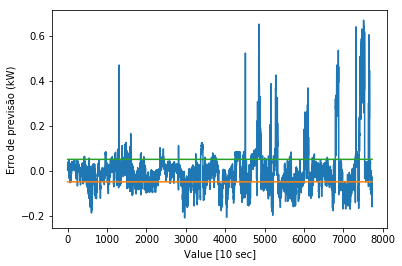

In [27]:
x = np.arange(1, len(y_testing)+1, 1)
y = error

plt.errorbar(x = x, y = error)
plt.errorbar(x = x, y = limit_low)
plt.errorbar(x = x, y = limit_high)
plt.xlabel('Value [10 sec]')
plt.ylabel('Erro de previsão (kW)')
plt.show()

O modelo acima descrito corresponde a todos os errros durante a time-series. No entando, o artigo de Schlechtinge, Santos e Achiche (2013), fala que o erro deve ser analisado por lotes. Para esse banco de dados, os de erro serão analisados por média horária. Como cada valor corresponde a um intervalo de 10 min, a cada 6 erros será tirada a média entre eles.

In [28]:
# definindo função que separa em lotes 1 hora

def hour_batches_mean(data):
    how_many = len(data)//6
    error_batches = np.ones((how_many, 1))
    for i in range(how_many):
        for j in range(6):
            error_batches[i] += data[6*i + j]
            
            
        error_batches[i] = data[i]/6
    return error_batches

In [29]:
error_hour_mean = error.copy()
error_batches = hour_batches_mean(error_hour_mean)

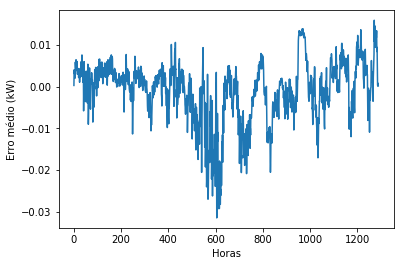

In [30]:
# grafico do erro em medição horária

y = error_batches
x = x = np.arange(1, len(error_batches)+1, 1)

plt.errorbar(x = x, y = error_batches)
#plt.errorbar(x = x, y = limit_low)
#plt.errorbar(x = x, y = limit_high)
plt.xlabel('Horas')
plt.ylabel('Erro médio (kW)')
plt.show()

#### 6.2 Valor de saída real

Aplicando a formual de normalização de forma inversa para encontrar valores reais

In [35]:
print(y_testing)
print(y_testing.dtype)

[[0.24830879]
 [0.27157787]
 [0.1996236 ]
 ...
 [0.46544957]
 [0.60825038]
 [0.69518403]]
float64


In [39]:
a = df['LV ActivePower (kW)'].max()
b = df['LV ActivePower (kW)'].min()

y_testing_real = y_testing*(a-b) + b
testing_real = testing*(a-b) + b
print(a)

3618.73291015625


In [38]:
print(y_testing_real)

[[ 898.58477783]
 [ 982.78869629]
 [ 722.4074707 ]
 ...
 [1684.35302734]
 [2201.10693359]
 [2515.6940918 ]]


In [34]:
print(testing_real)

[[ 904.2378]
 [1069.6274]
 [ 789.7157]
 ...
 [1120.9224]
 [1617.9114]
 [2066.235 ]]


In [88]:
error_real = testing_real - y_testing_real

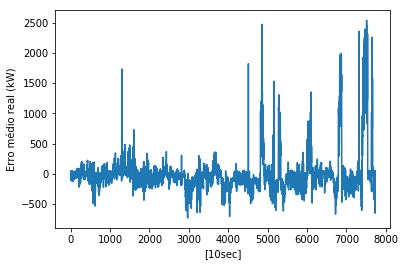

In [92]:
y = error_real
x = x = np.arange(1, len(error_real)+1, 1)

plt.errorbar(x = x, y = error_real)
#plt.errorbar(x = x, y = limit_low)
#plt.errorbar(x = x, y = limit_high)
plt.xlabel('[10sec]')
plt.ylabel('Erro médio real (kW)')
plt.show()

Passando para lotes de uma hora

In [90]:
error_hour_mean_real = error_real.copy()
error_batches_real = hour_batches_mean(error_hour_mean_real)

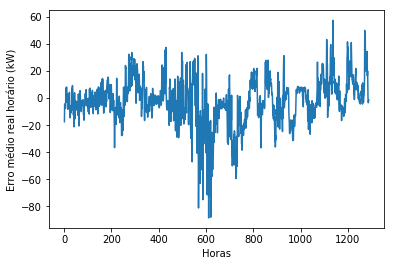

In [91]:
# grafico do erro em medição horária

y = error_batches_real
x = x = np.arange(1, len(error_batches_real)+1, 1)

plt.errorbar(x = x, y = error_batches_real)
#plt.errorbar(x = x, y = limit_low)
#plt.errorbar(x = x, y = limit_high)
plt.xlabel('Horas')
plt.ylabel('Erro médio real horário (kW)')
plt.show()

Ao analisar os gráficos de controle, vemos que mais ou menos a partir de 550 horas de operação, a turbina sai muito do comportamento esperado. O que pode ser um sinal de mal funcionamento.

### 7. Ajustes

In [93]:
df.corr()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
LV ActivePower (kW),1.000000,0.943495,0.973266,0.020504
Wind Speed (m/s),0.943495,1.000000,0.950241,0.036232
Theoretical_Power_Curve (KWh),0.973266,0.950241,1.000000,-0.008058
Wind Direction (°),0.020504,0.036232,-0.008058,1.000000


No quadro acima pode-se ver que a potência de saída tem uma correlação forte com a velocidade do vento, mas pequena em relação a direção do vento. Dessa forma, o modelo que leva em consideração a direção do vento não deve ter bons resultados. Dessa forma, vamos transformar a direção do vento em uma variável categórica. Essa variável será adicionada a rede neural mais adiante para testar seu desempenho com, e sem o one hot encoding.

In [98]:
wd_train = np.array(train_data['Wind Direction (°)'].copy())

for i in range(len(wd_train)):
    if wd_train[i] < 90:
        wd_train[i] = 1
    elif 90 <= wd_train[i] < 180:
        wd_train[i] = 2
    elif 180 <= wd_train[i] < 270:
        wd_train[i] = 3
    else:
        wd_train[i] = 4
        
wd_train

array([3., 3., 4., ..., 1., 1., 1.])

In [135]:
#utilizando one hot encoding

wd_dummies = pd.get_dummies(wd_train)
wd_dummies.head()

,1.0,2.0,3.0,4.0
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,1,0


In [143]:
wd_dummies.columns = ['0-90°','90°-180°','180°-270°','270°-360°']
wd_dummies.head()

,0-90°,90°-180°,180°-270°,270°-360°
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,0,0,0,1
4,0,0,1,0


Escalonando os dados de treinamento

In [169]:
a = df['Wind Speed (m/s)'].max()
b = df['Wind Speed (m/s)'].min()

train_data_with_dummies = train_data['Wind Speed (m/s)'].copy()
train_data_with_dummies = (train_data_with_dummies-b)/(a-b)
train_data_with_dummies = np.array(train_data_with_dummies).reshape(-1, 1)
train_data_with_dummies

print(train_data_with_dummies.dtype)

float64


Unindo dummies as features

In [170]:
wd_dummies = np.array(wd_dummies)
wd_dummies = wd_dummies.astype(float)
print(wd_dummies.dtype)

float64


In [171]:
train_data_with_dummies = np.concatenate((train_data_with_dummies, wd_dummies), axis = 1)

Definindo nova rede neural, com 5 entradas

In [174]:
# definindo o modelo keras

model2 = Sequential()
model2.add(Dense(5, input_dim = 5, activation = 'sigmoid'))
model2.add(Dense(1, activation = 'linear'))

In [175]:
# compilando o modelo keras

model2.compile(loss='mean_squared_error', optimizer = 'adam')

treinando o modelo 2

In [176]:
# fitting the model

X= train_data_with_dummies
y= targets_train

model2.fit(X, y, epochs = 10, batch_size = 1)

Epoch 1/10
30922/30922 [==============================] - 23s 755us/step - loss: 0.0283
Epoch 2/10
30922/30922 [==============================] - 21s 691us/step - loss: 0.0089
Epoch 3/10
30922/30922 [==============================] - 21s 693us/step - loss: 0.0084
Epoch 4/10
30922/30922 [==============================] - 22s 699us/step - loss: 0.0076
Epoch 5/10
30922/30922 [==============================] - 21s 687us/step - loss: 0.0067
Epoch 6/10
30922/30922 [==============================] - 22s 706us/step - loss: 0.0058
Epoch 7/10
30922/30922 [==============================] - 23s 746us/step - loss: 0.0052
Epoch 8/10
30922/30922 [==============================] - 21s 692us/step - loss: 0.0049
Epoch 9/10
30922/30922 [==============================] - 22s 698us/step - loss: 0.0048
Epoch 10/10
30922/30922 [==============================] - 22s 700us/step - loss: 0.0048


In [182]:
# evaluating training loss

loss = model2.evaluate(X, y)
print(loss)

30922/30922 [==============================] - 1s 20us/step
0.00512784070118088


Manipulando dados de teste

In [181]:
wd_test = np.array(test_data['Wind Direction (°)'].copy())

for i in range(len(wd_test)):
    if wd_test[i] < 90:
        wd_test[i] = 1
    elif 90 <= wd_test[i] < 180:
        wd_test[i] = 2
    elif 180 <= wd_test[i] < 270:
        wd_test[i] = 3
    else:
        wd_test[i] = 4
        
wd_dummies_test = pd.get_dummies(wd_test)

test_data_with_dummies = test_data['Wind Speed (m/s)'].copy()
test_data_with_dummies = (test_data_with_dummies-b)/(a-b)
test_data_with_dummies = np.array(test_data_with_dummies).reshape(-1, 1)

wd_dummies_test = np.array(wd_dummies_test)
wd_dummies_test = wd_dummies_test.astype(float)

print(test_data_with_dummies.shape)
print(wd_dummies_test.shape)

test_data_with_dummies = np.concatenate((test_data_with_dummies, wd_dummies_test), axis = 1)

(7730, 1)
(7730, 4)


testando a rede neural

In [183]:
# making predictions out of the test set

testing2 = model2.predict(test_data_with_dummies)

testing2 = np.array(testing2)
print(testing2.shape)

(7730, 1)


In [184]:
y_testing = np.array(dfnt['LV ActivePower (kW)']).reshape(-1, 1)
error2 = testing2 - y_testing

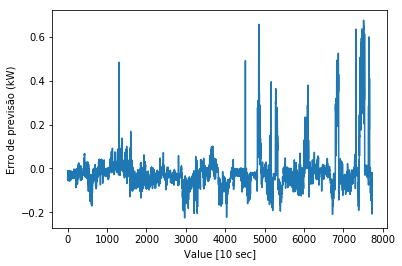

In [185]:
# plotting error

x = np.arange(1, len(y_testing)+1, 1)
y = error2

plt.xlabel('Value [10 sec]')
plt.ylabel('Erro de previsão (kW)')
plt.plot(x, y) 